In [1]:
!nvidia-smi

Fri Sep  6 09:58:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   46C    P8             17W /   80W |     566MiB /   6144MiB |     26%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [40]:
# import libraries
import seaborn as sns
import pandas as pd 
import numpy as np 
import torch
import random
import os, sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import trange

from scipy.linalg import inv, cho_factor, cho_solve
import glob
import optuna

random.seed(1)
from Kalman_module_trial import *
from augment import *
from normalize import Normalization
from model import lstm_encoder, lstm_decoder, lstm_seq2seq, EnsembleModel, xavier_initialize, he_initialize
from utils import *
from dataset import TrajDataset
# from dataset import TrajDataset

#
# from ray import tune
# # from ray.air import Checkpoint, session
# from ray.tune.schedulers import ASHAScheduler

writer = SummaryWriter("runs/")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [41]:
path = "Dataset/"

# List of flies sequence [hotel, eth, zara01, zara02]:
listoffiles = glob.glob(os.path.join(path,"*.txt"))

# print(listoffiles)
look_back = 8
forward_pred = 12


csv_columns = ["frame_id", "agent_id", "pos_x", "pos_z", "pos_y", "vel_x", "vel_z", "vel_y"]
test_data_name = 'obsmat_eth.txt'
train_data_name = ['obsmat_zara01.txt','obsmat_zara02.txt','obsmat_hotel.txt','obsmat_ucy.txt']
dataframes_train = [pd.read_csv(f,sep=r"\s+", header=None, names=csv_columns) for f in listoffiles if f.endswith(tuple(train_data_name))]
dataframe_test = [pd.read_csv(f,sep=r"\s+", header=None, names=csv_columns) for f in listoffiles if f.endswith(test_data_name)]

'''
creates a pandas dataframe for the five pedestrian datasets. sub_df is the sub dataframe for each unique agent 
within the dataset that is concatenated to form the filtered_dfs.
'''
def create_df(dataframe):

    indices = [1000, 2000, 3000, 4000, 5000]
    if dataframe == dataframe_test:
        indices = [5000]
    filtered_dfs =[]
    idx = 0
    for df in dataframe:
    #     newdf = df.sort_values(by = 'agent_id')
        unique_id = np.unique(df['agent_id'])
        # print(newdf.head(50))


        sub_dfs, filtered_ids = [], []
        for id in unique_id:
            sub_df = df[df['agent_id'] == id].copy()
        #     print("sub_df len : {}".format(len(sub_df)))
            if len(sub_df) < (look_back + forward_pred):
                continue
            filtered_ids.append(id)
            sub_df['agent_id'] = sub_df['agent_id'] + indices[idx]
            sub_df = sub_df.sort_values(by = 'frame_id')
            sub_dfs.append(sub_df)
    #     print("length of filtered_ids:", len(filtered_ids))
        filtered_dfs.append(pd.concat(sub_dfs, ignore_index=True))
        idx += 1

    data = pd.concat(filtered_dfs, axis = 0)
#     print(data)
    return data



In [42]:

# np.set_printoptions(threshold=sys.maxsize)
# np.unique(df['agent_id'])

In [43]:
# Create train and test dataframe:
train_df = create_df(dataframes_train)
test_df = create_df(dataframe_test)
df = pd.concat([train_df, test_df], axis = 0)
agents = np.unique(df['agent_id'])
test_agents = np.unique(test_df['agent_id'])
random.shuffle(agents)
random.shuffle(test_agents)


training_fraction = 0.85
num_train_agents = int(training_fraction*len(agents))
train_agents = agents[:num_train_agents]


train_agents = train_agents[:300]
test_agents = test_agents[:60]

test_agents  = set(test_agents) - set(test_agents).intersection(set(train_agents))
test_agents = list(test_agents)

# Unique train, test and val agents
val_fraction = 0.15
num_val_agents = int(val_fraction * len(train_agents))
val_agents = train_agents[:num_val_agents]
train_agents = train_agents[num_val_agents:]

# Indices of val, train and test agents
print("common elements if any:", set(train_agents).intersection(set(val_agents)))
print("common elements if any:", set(train_agents).intersection(set(test_agents)))
print("common elements if any:", set(test_agents).intersection(set(val_agents)))
test_agents = test_agents

common elements if any: set()
common elements if any: set()
common elements if any: set()


In [44]:
test_agents

[5123.0,
 5125.0,
 5254.0,
 5131.0,
 5263.0,
 5265.0,
 5266.0,
 5011.0,
 5140.0,
 5143.0,
 5148.0,
 5022.0,
 5281.0,
 5162.0,
 5036.0,
 5040.0,
 5041.0,
 5171.0,
 5177.0,
 5052.0,
 5186.0,
 5314.0,
 5316.0,
 5070.0,
 5071.0,
 5072.0,
 5201.0,
 5202.0,
 5073.0,
 5326.0,
 5198.0,
 5206.0,
 5204.0,
 5337.0,
 5210.0,
 5082.0,
 5220.0,
 5350.0,
 5352.0,
 5230.0,
 5362.0,
 5247.0]

In [45]:
# # Obtain the unique train and test agents:
# '''
# Splitting agents randomly based on agent id into train and test agents 
# '''
# training_fraction = 0.85
# unique_agent_ids = np.unique(data['agent_id'])


# train_agents = np.random.choice(unique_agent_ids, size= int(training_fraction*len(unique_agent_ids)), replace = False)
# test_agents = set(unique_agent_ids) -set(train_agents)

# train_agents = train_agents
# test_agents  = np.array(list(test_agents))

# print("common elements if any:", set(train_agents).intersection(set(test_agents)))
# print(f"Train_agents :{len(train_agents)} \t Test_agents :{len(test_agents)} \t Total_agents: {len(unique_agent_ids)} ") 

# # Split the data into train and test data:
# train_df = data[data['agent_id'].isin(train_agents)]
# test_df = data[data['agent_id'].isin(test_agents)]

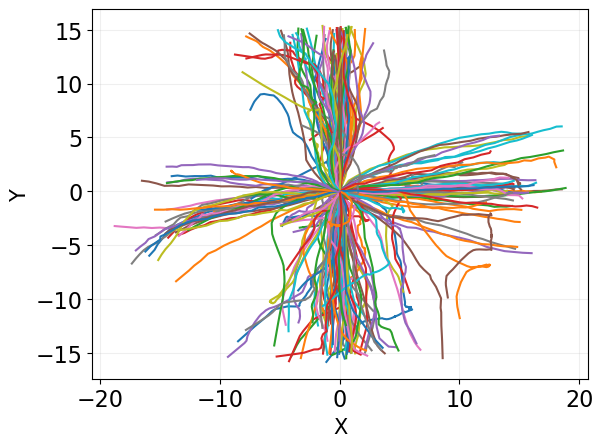

In [46]:
'''
Plotting the trajectories present within train data.
(pos_x, pos_y): (x,y) coordinate of pedestrian about the origin
'''

timesteps_arr = []
index = []
hist_x = []
hist_y = []
thres1 = look_back + forward_pred
agent_ids = [] 

for agent_id in train_agents:
    sub_df = df[df['agent_id'] == agent_id]
    frame, posx, posy = sub_df['frame_id'], sub_df["pos_x"] - 1*sub_df["pos_x"].iloc[0] , sub_df["pos_y"] - 1*sub_df["pos_y"].iloc[0]
    plt.plot(posx, posy, markersize=10, markerfacecolor ='white', label=f"Agent_id:%.0f"%agent_id)
'''
    if (posy.iloc[-1] - posy.iloc[0] >5):
      index.append(agent_id)
      filtered_df = data[data['agent_id'].isin(index)]
      frame, posx, posy = filtered_df['frame_id'], sub_df['pos_x'], sub_df['pos_y']
'''
        

# plt.legend(loc = "upper right")
plt.xlabel("X", fontsize=15)
plt.ylabel("Y", fontsize=15)
plt.grid("on", alpha=0.2)
plt.locator_params(integer=True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('Single_Trajectory.pdf', bbox_inches='tight',  dpi = 300)
plt.show()

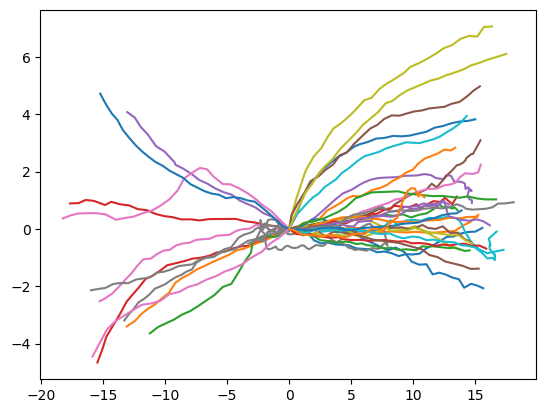

In [47]:
'''
Plotting the trajectories present within test data.
The test data is out of distribution with train data.
'''

for agent_id in test_agents:
    sub_df = df[df['agent_id'] == agent_id]
    frame, posx, posy = sub_df['frame_id'], sub_df["pos_x"] - 1*sub_df["pos_x"].iloc[0] , sub_df["pos_y"] - 1*sub_df["pos_y"].iloc[0]
    plt.plot(posx, posy, markersize=10, markerfacecolor ='white', label=f"Agent_id:%.0f"%agent_id)

In [48]:
'''
This creates train and test data from the data frame. 
data_x: [x,y,u,v] shape: N,look_back(8),features(4)
data_y: [x,y,u,v] shape: N,forward_pred(12),features(12)
'''

def create_dataset(dataframe, agent_id_list, lookback, forward_pred, skip, coord_trnsf ="original"):
    
    '''
    Create_dataset function generates trajectory through a sliding window approach of skip = 1. The 
    shape of train/test dataset: N_traj x  20 (lookback(8) + forwardpred(12))  x 4 (num_fea = [xyuv]).
    
    Parameters:
    - dataframe: DataFrame containing trajectory data.
    - agent_id_list: List of agent IDs to consider for generating the dataset.
    - lookback: Number of past steps to consider.
    - forward_pred: Number of future steps to predict.
    - coord_trnsf: Coordinate transformation mode ('original', 'first_obs', 'last_obs').
    - skip: Step size for the sliding window.
    
    Below, we present list of coordinate transformations:
    1. original: If the trajectories are kept as original without any coordinate transformation.
    2. first_obs: Trajectories are transformed such that the start of each trajectory is origin.
    3. last_obs: Trajectories are transformed such that the last obs point i.e. N_seq = 8 is at origin(0,0) 
    '''
    data_x = []
    data_y = []
    for agent_id in agent_id_list:
        sub_df = dataframe[dataframe["agent_id"]==agent_id]

    # Change the coordinate frame of the Pedestrian Trajectory:
    # sub_df["pos_x"] = sub_df["pos_x"] -sub_df["pos_x"].iloc[0]
    # sub_df["pos_y"] = sub_df["pos_y"] -sub_df["pos_y"].iloc[0]


    # print(sub_df["pos_x"].iloc[0], sub_df["pos_y"].iloc[0])
         
            
        for j in range(0, len(sub_df)-lookback-forward_pred+1, skip):
            if (coord_trnsf == "original"):
                factor = 0
                origin = j
            elif (coord_trnsf == "first_obs"):
                factor = 1
                origin = j
            elif (coord_trnsf == "last_obs"):
                factor = 1
                origin = j+lookback-1
            else:
                raise ValueError("Invalid coordinate transformation mode.")

            df1 = sub_df.iloc[j:j+lookback, [dataframe.columns.get_loc(c) for c in ["pos_x", "pos_y"]]]\
            - factor*sub_df.iloc[origin, [dataframe.columns.get_loc(c) for c in ["pos_x","pos_y"]]]
            df2 = sub_df.iloc[j:j+lookback, [dataframe.columns.get_loc(c) for c in ["vel_x","vel_y"]]]
            data_x.append(pd.concat([df1,df2], axis = 1)) # pos_x = 3, pos_y = 5, .... (from the indices of the dataframe)


            df3 = sub_df.iloc[j+lookback:j+lookback+forward_pred, [dataframe.columns.get_loc(c) for c in ["pos_x","pos_y"]]]\
            - factor*sub_df.iloc[origin, [dataframe.columns.get_loc(c) for c in ["pos_x","pos_y"]]]
            df4 = sub_df.iloc[j+lookback:j+lookback+forward_pred, [dataframe.columns.get_loc(c) for c in ["vel_x","vel_y"]]]
            data_y.append(pd.concat([df3,df4], axis =1))

    return np.array(data_x), np.array(data_y)

In [49]:
# Create the train and test dataset:
skip = 2 # step size for sliding window
X_train, y_train = create_dataset(df, train_agents, look_back, forward_pred, skip, coord_trnsf="last_obs")
X_val, y_val = create_dataset(df, val_agents, look_back, forward_pred, skip, coord_trnsf="last_obs")
X_test,y_test = create_dataset(df, test_agents, look_back, forward_pred, skip, coord_trnsf="last_obs")

# Concat to obtain complete train and test traj: 
train_traj = np.concatenate((X_train, y_train), axis = 1)
val_traj = np.concatenate((X_val,y_val), axis = 1)
test_traj = np.concatenate((X_test, y_test), axis = 1)

In [50]:
test_traj.shape

(306, 20, 4)

ID: 956


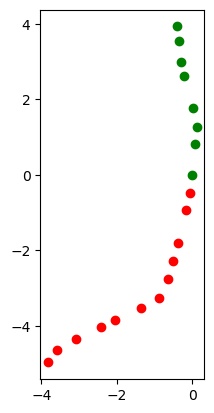

In [51]:
fig, ax = plt.subplots()
for id in np.random.choice(train_traj.shape[0], 1, replace=False):
    plt.scatter(train_traj[id,:look_back,0],train_traj[id,:look_back,1], color='g')
    plt.scatter(train_traj[id,look_back:,0],train_traj[id,look_back:,1], color='r')
    print("ID:",id)
ax.set_aspect('equal', adjustable='box')
    
plt.show()

In [52]:
# Data Augmentation using random rotation and swap
augmenter = Augmentation()
swap_fraction = 0.0 # Randomly swap 40% trajectories
num_traj_swap = int(swap_fraction*len(train_traj))
swap_traj = augmenter.swap_xyuv(train_traj[:num_traj_swap,:,:])
rotated_traj = augmenter.random_rotate(train_traj[num_traj_swap:,:,:])
augmented_traj = np.concatenate((swap_traj,rotated_traj),axis = 0)

In [53]:
train_agents[:num_traj_swap].shape

(0,)

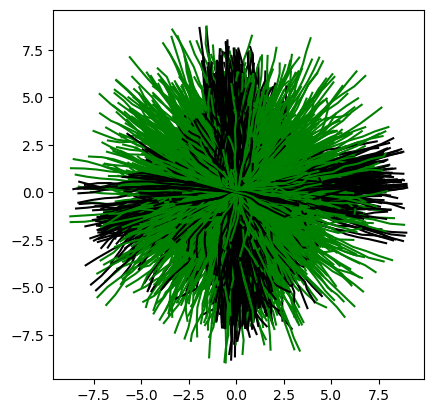

In [54]:
fig,ax = plt.subplots()
for id in range(train_traj.shape[0]):
    ax.plot(train_traj[id,:,0],train_traj[id,:,1], color='k')
    ax.plot(augmented_traj[id,:,0],augmented_traj[id,:,1], color='g')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [55]:
train_traj = np.concatenate((augmented_traj,train_traj), axis =0)
# train_traj = rotated_train_traj

In [56]:
train_traj.shape

(4774, 20, 4)

In [57]:
train_traj[0,:,:][np.newaxis,:].shape

(1, 20, 4)

In [60]:
'''
Function get_N_trajectories is called to obtain num_traj = 7 different sampled trajectories 
from the distribution obtained using KF. 
batch_traj_test: N_test, 7, 20, 4
batch_traj_mu:  N_test, 7, 20, 4
batch_traj_cov:  N_test, 7, 20, 4 [contains only diagonal elements of the variables; no off-diagonal]
'''

num_traj = 5
f = 0.1 # 5% prior sensing uncertainty to KF. DO NOT increase uncertainty beyond 10%, it will mess up training 

def generate_sampled_trajectories(traj, num_traj,f):
    f_traj, f_mu, f_cov =[], [], []
    # for id in np.random.choice(train_traj.shape[0],5):  
    for id in range(traj.shape[0]):
        noise = np.random.normal(0, 0.25*f,1)
        f_new = f + noise
        X_seq = traj[id,:,:]
        trajectories, mus, covs = get_N_trajectories(X_seq, num_traj, f_new)
        f_traj.append(trajectories)
        f_mu.append(mus)
        f_cov.append(covs)


    batch_traj = np.squeeze(f_traj)
    batch_cov = np.squeeze(f_cov)
    batch_mu = np.squeeze(f_mu)
    
    return batch_traj, batch_mu, batch_cov

In [62]:
N_train_traj, train_mu, train_cov = generate_sampled_trajectories(train_traj, num_traj,f)
N_val_traj, val_mu, val_cov = generate_sampled_trajectories(val_traj, num_traj,f)
N_test_traj, test_mu, test_cov = generate_sampled_trajectories(test_traj, num_traj,f)

In [63]:
train_mu.shape

(4774, 5, 20, 4)

In [64]:
print(N_train_traj.shape)
print(N_val_traj.shape)
print(N_test_traj.shape)

(4774, 5, 20, 4)
(564, 5, 20, 4)
(306, 5, 20, 4)


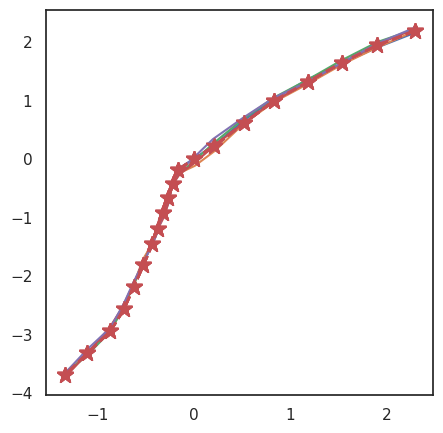

In [65]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set_theme(style='white')
# .detach().cpu().numpy()
id = 1581
for i in range(N_train_traj.shape[1]):
    plt.plot(N_train_traj[id,i, :, 0], N_train_traj[id,i, :, 1])
    plt.plot(train_traj[id,:,0],train_traj[id,:,1], lw=2., ms=12., marker='*', color="r", linestyle="dashed")
#     plt.ylim([6,10])
plt.show()

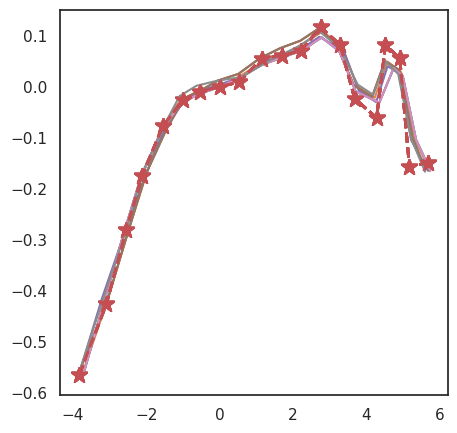

In [66]:
# Plot showing test trajectories for a particular ID
sns.set(rc={'figure.figsize':(5,5)})
sns.set_theme(style='white')
# .detach().cpu().numpy()
id = 20
for traj in (np.random.choice(N_test_traj.shape[1],8)):
    plt.plot(N_test_traj[id,traj, :, 0], N_test_traj[id,traj, :, 1])
    plt.plot(test_traj[id,:,0],test_traj[id,:,1], lw=2., ms=12., marker='*', color="r", linestyle="dashed")
#     plt.ylim([6,10])
plt.show()

<Figure size 1000x300 with 0 Axes>

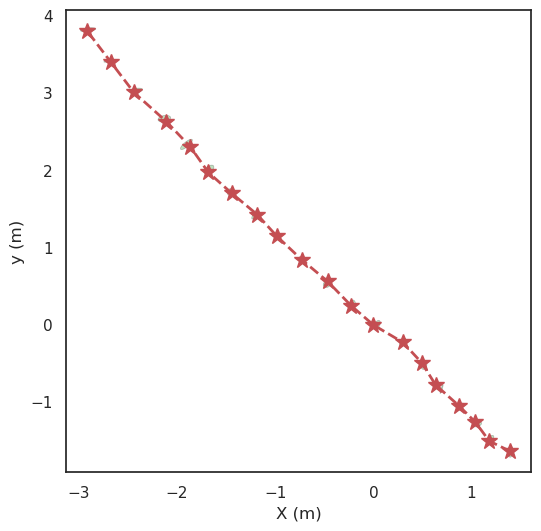

In [67]:
from matplotlib.patches import Ellipse
import matplotlib as mpl

# plt.style.use('seaborn-white')
plt.figure(figsize=(10,3))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharex=False, sharey=True)

for point in range(20):
#     ax.scatter(batch_traj[id,:,point,0], batch_traj[id,:,point,1], color="b")
    ax.plot(train_traj[id,point,0], train_traj[id,point,1], lw= 4 -0.15*point, ms=12., marker='*', color="r", linestyle="dashed")

    cov = np.cov(N_train_traj[id,:,point,0],N_train_traj[id,:,point,1] ) 
    lambda_, v_ = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
#         print(lambda_tot)

    for j in range(1,2):
        ell1 = Ellipse(xy = (N_train_traj[id,:,point,0].mean(), N_train_traj[id,:,point,1].mean()),
                 width = (lambda_[0] *1) * j* 2 ,
                 height = (lambda_[1] *1) *j* 2,
                    angle = np.rad2deg(np.arccos((v_[0,0]))),
                     color = 'black',  lw = 0.5) 
        ell1.set_facecolor('green')
        ell1.set_alpha(0.25)
        ax.add_artist(ell1)
# ax.axis('equal')
ax.plot(train_traj[id,:,0],train_traj[id,:,1], lw=2, ms=6., marker='*', color="r", linestyle="dashed")
plt.xlabel('X (m)')
plt.ylabel('y (m)')
plt.show()

In [68]:
# Loading the data on the device
num_fea = 2
batch_traj_temp = torch.tensor(N_train_traj[:,:,:,:num_fea]).float().to(device) # shape: batch, num_traj, seq, features
# X_train, y_train = torch.tensor(X_train[:,:,:num_fea]).float().to(device), torch.tensor(y_train[:,:,:num_fea]).float().to(device)
X_train_KF, y_train_KF = torch.split(batch_traj_temp, [8,12], dim = 2) # shape: batch, num_traj, seq, features

batch_traj_test_temp = torch.tensor(N_test_traj[:,:,:,:num_fea]).float().to(device)
# X_test, y_test = torch.tensor(X_test[:,:,:num_fea]).float().to(device), torch.tensor(y_test[:,:,:num_fea]).float().to(device)
X_test_KF, y_test_KF = torch.split(batch_traj_test_temp, [8,12], dim = 2) # shape: batch, num_traj, seq, features


def normalize_data(data):
    reshaped_data = data.reshape(-1, data.shape[-1])
    
    mean = torch.mean(reshaped_data, dim = 0)
    std = torch.std(reshaped_data, dim = 0)
    
    normalized_data = (data - mean)/std
    return normalized_data, mean, std

def denormalize_data(data, mean, std):
    denormalized_data = (data * std) + mean
    return denormalized_data

def generate_dataloader(mu, cov, num_fea, normalize = True):
    gaussian_traj =  np.concatenate([mu[:,:,:,:num_fea], cov[:,:,:,:num_fea]], axis =3) # shape: batch, num_traj, seq, features *2
    gaussian_traj = torch.tensor(gaussian_traj).float().to(device)
    if normalize:
        gaussian_traj, mean, std = normalize_data(gaussian_traj)
        input_traj, output_traj = torch.split(gaussian_traj, [8,12], dim = 2)
        return gaussian_traj, input_traj, output_traj, mean, std
    
    mean, std  = None, None
    input_traj, output_traj = torch.split(gaussian_traj, [8,12], dim = 2)
    return gaussian_traj, input_traj, output_traj
    
    
gaussian_train_traj, train_input, train_output = generate_dataloader(train_mu, train_cov, num_fea, normalize = False)
gaussian_val_traj, val_input, val_output = generate_dataloader(val_mu, val_cov, num_fea, normalize = False)
gaussian_test_traj, test_input, test_output = generate_dataloader(test_mu, test_cov, num_fea, normalize = False)

# Look for other augmentation at the end of the simulation after ADE/FDE computation

In [69]:
test_output[:10, 0,:,:]

tensor([[[ 6.3788e-01, -1.5123e-02,  5.2985e-03,  1.1827e-05],
         [ 1.0926e+00, -4.2404e-02,  5.2909e-03,  1.1827e-05],
         [ 1.7184e+00, -1.1914e-01,  5.2875e-03,  1.1827e-05],
         [ 2.2378e+00, -1.5848e-01,  5.2859e-03,  1.1827e-05],
         [ 2.7688e+00, -1.7950e-01,  5.2852e-03,  1.1827e-05],
         [ 3.3506e+00, -2.5058e-01,  5.2848e-03,  1.1827e-05],
         [ 3.9090e+00, -2.6334e-01,  5.2847e-03,  1.1827e-05],
         [ 4.5357e+00, -3.1119e-01,  5.2846e-03,  1.1827e-05],
         [ 5.1242e+00, -3.8549e-01,  5.2846e-03,  1.1827e-05],
         [ 5.6857e+00, -3.6376e-01,  5.2846e-03,  1.1827e-05],
         [ 6.2747e+00, -3.4681e-01,  5.2846e-03,  1.1827e-05],
         [ 6.7813e+00, -3.0773e-01,  5.2845e-03,  1.1827e-05]],

        [[ 5.4949e-01, -8.4047e-02,  9.2812e-03,  1.8171e-05],
         [ 1.1917e+00, -1.2436e-01,  9.2683e-03,  1.8053e-05],
         [ 1.7474e+00, -1.5450e-01,  9.2625e-03,  1.7987e-05],
         [ 2.2739e+00, -2.1436e-01,  9.2598e-03,  1.7

In [70]:
# Create the tensor dataset
from torch.utils import tensorboard
from torch.utils.data import DataLoader,TensorDataset
from torchsummary import summary


idx = list(range(num_traj))
random.shuffle(idx)


batch_size = 32
hidden_size = 256
num_fea = train_input.shape[3]
preds, sigmas = [],[]
losses = []
train_MSE, test_MSE = [], []
min_val = -1
max_val = 1

# def objective(trial):
     # Log trial information
# print(f"Starting trial {trial.number} with parameters: {trial.params}")


# Define search space:
'''
optuna results:
Best trial:
Value: 0.03539485640690795
params: 
 learning_rate: 0.001597064489725669
 teacher_forcing_ratio: 0.18259437319603056
 batch_size: 32
 optimizer_name: RMSProp
 hidden_state: 256

'''


#     learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2) 
#     teacher_forcing_ratio = trial.suggest_float('teacher_forcing_ratio', 0.0, 1.0)
#     batch_size = trial.suggest_categorical('batch_size',[32,64,128,256])
#     optimizer_name = trial.suggest_categorical('optimizer_name',['Adam','SGD','RMSProp'])
#     hidden_size = trial.suggest_categorical('hidden_size',[64, 128, 256])
#     init_weight = trial.suggest_categorical('init_weight',['xavier_initialize','he_initialize'])

#     hidden_size = np.random.choice([64,128,256])
deep_ensemble = EnsembleModel(input_size = num_fea, hidden_size = hidden_size,  device = device, num_models=3, init_weight = xavier_initialize)


ensemble_val_loss = []
for i, model  in enumerate(deep_ensemble.models):

    print(i)
#     train_data = TrajDataset(train_input[:,i,:,:], train_output[:,i,:,:], min_val = min_val, max_val = max_val)
#     val_data =  TrajDataset(val_input[:,i,:,:], val_output[:,i,:,:], min_val = min_val, max_val = max_val)
#     test_data = TrajDataset(test_input[:,i,:,:], test_output[:,i,:,:], min_val = min_val, max_val = max_val)
    
    train_data = TensorDataset(train_input[:,i,:,:], train_output[:,i,:,:])
    val_data =  TensorDataset(val_input[:,i,:,:], val_output[:,i,:,:])
    test_data = TensorDataset(test_input[:,i,:,:], test_output[:,i,:,:])

    # Train, validataion and Test DataLoader
    train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = False)
    val_loader =   DataLoader(val_data, batch_size = batch_size, shuffle = False)
    test_loader =  DataLoader(test_data, batch_size = batch_size, shuffle = False)
    
#     train_features, train_labels = next(iter(train_loader))
#     print('Train Features :',train_features)
#     print('Train labels :',train_labels)
    
    # Load the model
#     model = lstm_seq2seq(input_size = num_fea, hidden_size = 128, device = device)
#     print(model)
    
#     break
    
    loss, val_loss = model.train_model(device,
                             train_loader, 
                             val_loader,
                             n_epochs = 100, 
                             target_len = forward_pred, 
                             batch_size = batch_size, 
                             beta = 0.5,
                             training_prediction ='teacher_forcing', 
                             teacher_forcing_ratio = 0.2, 
                             learning_rate = 0.0015, 
                             dynamic_tf = False,
                             optimizer_name = 'RMSProp',
                             hidden_size = hidden_size
                             )

    print('Model No.{} trained.'.format(i+1))
    valid_val_losses = [loss for loss in val_loss if not np.isnan(loss)]
    if valid_val_losses:
        last_valid_val_loss = valid_val_losses[-1]
    else:
        last_valid_val_loss = np.inf
    print(last_valid_val_loss)
    ensemble_val_loss.append(last_valid_val_loss)

# # summarize history for loss
# #     plt.plot(history.history['loss'])
# #     plt.plot(history.history['val_loss'])
# #     plt.title('model loss')
# #     plt.ylabel('loss')
# #     plt.xlabel('epoch')
# #     plt.legend(['train', 'test'], loc='upper left')
# #     plt.show()
#     plt.figure(figsize=(6,4), dpi=150)
#     plt.plot(loss, lw=2.,color = 'r')
#     plt.plot(val_loss,lw=2.,color = 'b')
#     # plt.yscale("log")
#     plt.grid("on", alpha=0.2)
#     plt.ylabel("NLL Loss", fontsize=12)
#     plt.xlabel("Epochs", fontsize=12)
#     plt.show()
    
    
    min_logvar, max_logvar = -4, 4

    y_train_pred = model.predict(val_input[:,i,:,:], forward_pred, device)
    # y_train_pred = model.predict(X_train, target_len=forward_pred)
#     y_train_pred_mean_mu, y_train_pred_mean_sigma, y_train_pred_logvar = y_train_pred[:,:,:int(num_fea/2)], torch.abs(y_train_pred[:,:,int(num_fea/2):num_fea]),  y_train_pred[:,:,num_fea:]#target_len, b, 8
    y_train_pred_mu,   y_train_state_logvar, y_train_pred_logvar = y_train_pred[:,:,:int(num_fea/2)], (y_train_pred[:,:,int(num_fea/2):num_fea]), (y_train_pred[:,:,num_fea:])#target_len, b, 8
    y_train_state_var = torch.exp(y_train_state_logvar)
    y_train_pred_logvar = torch.clamp(y_train_pred_logvar, min=min_logvar, max=max_logvar)
    y_train_pred_mean = torch.cat((y_train_pred_mu, y_train_state_var),2)
#     y_train_pred_mean = denormalize_data(y_train_pred_mean, train_mean,  train_std)
    
    # Denormalize Data:
    mse_train = ((y_train_pred_mean - val_output[:,i,:,:num_fea])**2).mean()
    print(f"Train MSE: {mse_train}")

    y_test_pred = model.predict(test_input[:,i,:,:], target_len=forward_pred, device = device)
    # y_test_pred = model.predict(X_test, target_len=forward_pred)
#     y_test_pred_mean_mu, y_test_pred_mean_sigma, y_test_pred_logvar = y_test_pred[:,:,:int(num_fea/2)],  torch.abs(y_test_pred[:,:,int(num_fea/2):num_fea]), y_test_pred[:,:,num_fea:]#target_len, b, 8
    y_test_pred_mu , y_test_state_logvar, y_test_pred_logvar = y_test_pred[:,:,:int(num_fea/2)], (y_test_pred[:,:,int(num_fea/2):num_fea]), (y_test_pred[:,:,num_fea:])#target_len, b, 8
    y_test_state_var = torch.exp(y_test_state_logvar)
    y_test_pred_logvar = torch.clamp(y_test_pred_logvar, min=min_logvar, max=max_logvar)
    y_test_pred_mean = torch.cat((y_test_pred_mu, y_test_state_var),2)
#     y_test_pred_mean = denormalize_data(y_test_pred_mean, train_mean,  train_std)
    
    # Denormalize Data:
    mse_test = ((y_test_pred_mean - test_output[:,i,:,:num_fea])**2).mean()
    print(f"Test MSE: {mse_test}")
    
#     train_MSE.append(mse_train)
#     test_MSE.append(mse_test)
#     losses.append(loss)
#     preds.append(y_test_pred_mean)
#     sigmas.append(y_test_pred_logvar)


TypeError: EnsembleModel.__init__() missing 4 required positional arguments: 'output_size', 'num_layers', 'dropout', and 'use_attention'

In [ ]:
# study = optuna.create_study(direction = 'minimize')
# study.optimize(objective, n_trials =30)

# print("Best trial:")
# trial = study.best_trial
# print("Value:", trial.value)
# print("params: ")
# for key, value in trial.params.items():
#     print(f" {key}: {value}")


# optuna.visualization.plot_param_importances(study)


In [ ]:
# Sigmoid function:
def sigmoid(list_x):
    return [1/(1+np.exp(-x)) for x in list_x]

# Inverse Function:
def inverse(list_x):
    return [1/(1e-4 + x) for x in list_x]

# relative loss:
def rel_loss(list_x):
    max_x = max(list_x)
    return [(max_x -x) for x in list_x]


# Weights:
def weights(list_x):
    return [x/sum(list_x) for x in list_x] 

# Weighted sum:
def weighted_sum(weights, array):
#     mu_ens = np.zeors_like(mu_preds[0])
    avg_ens = np.tensordot(weights, array, axes=([0], [0]))
    return avg_ens
        
    

In [ ]:
def calculate_aggressive_weights(val_losses):
    # Shift the losses so the smallest loss is close to zero
    shifted_losses = val_losses - np.min(val_losses)

    # Apply a more aggressive inverse scaling: Square the inverse of shifted losses
    # Adding a small constant to avoid division by zero in inverse calculation
    aggressive_inverse_losses = 1 / (1e-4 + shifted_losses ** 3)

    # Normalize the new set of weights
    aggressive_weights = aggressive_inverse_losses / np.sum(aggressive_inverse_losses)

    return aggressive_weights



In [ ]:
weights = calculate_aggressive_weights(ensemble_val_loss)
weights

In [ ]:
# # ensemble_val_loss = [0.053,0.01,0.014]
# inverse_list = inverse(ensemble_val_loss)
# rel_loss_list = rel_loss(ensemble_val_loss)

# # sigmoid_inv_list = sigmoid(inverse_list)
# # sigmoid_rel_loss_list = sigmoid(rel_loss_list)

# # Weights:
# weights_inv = weights(inverse_list)
# weights_rel_loss = weights(rel_loss_list)

In [ ]:
ensemble_predictions = []
for model in deep_ensemble.models:
    model.eval()
    
    with torch.no_grad():
        predictions = model.predict(test_input[:,0,:,:], target_len = forward_pred, device = device)
     
    ensemble_predictions.append(predictions)
ensemble_predictions = torch.stack(ensemble_predictions)    

In [ ]:
ensemble_predictions.shape
preds = torch.cat((ensemble_predictions[:,:,:,:int(num_fea/2)], torch.exp(ensemble_predictions[:,:,:,int(num_fea/2):int(num_fea)])),3)
sigmas = ensemble_predictions[:,:,:,int(num_fea):]
sigmas = torch.clamp(sigmas, min=min_logvar, max=max_logvar)
mu_preds = torch.Tensor(preds)
# mu_preds = denormalize_data(mu_preds, train_mean,  train_std)
sigma_preds = torch.Tensor(torch.exp(sigmas))

In [ ]:
preds[0,10,:,2:]

In [ ]:
test_output[10,1,:,2:]

In [ ]:
mu_preds.shape

In [ ]:
# Compute the ensemble mean and variance:
# mu_preds, sigma_preds =torch.stack(preds), torch.stack(sigmas) # Imp to convert a torch list to tensor

import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse

def plot_UQ(X_test, y_test, mus, sigmas, ground_cov, id_no=100):
    
    num_fea = mus.shape[3]
#     sigmas = np.exp(sigmas)
    mu_preds = mus
    fig, axs = plt.subplots(nrows = 4, ncols =1, figsize =(12,12), sharex= True, sharey=False)
    for n_ens in range(mu_preds.shape[0]):

        axs[n_ens].scatter(X_test[id_no,:,0],  X_test[id_no,:,1], color='g',marker='o',s =5, label = 'Input')
        axs[n_ens].plot(y_test[id_no,:,0],  y_test[id_no,:,1], color='r',alpha=0.5, marker='^', ms =3,label = 'Ground Truth' )
        axs[n_ens].plot(mu_preds[n_ens,id_no,:,0], mu_preds[n_ens,id_no,:,1], color='b', marker='d', alpha=0.85, ms = 3, label = 'NN state Estimate' )

        num_fea = mu_preds.shape[3]
        var_state_unc = (mu_preds[n_ens,:,:,2:4]) 

        state_cov = []
        pred_cov = []
        mu = []
        for pred in range(forward_pred): 

            mean = np.squeeze(mu_preds[n_ens,id_no, pred, :])
            cov_pred = np.squeeze(np.diag(sigmas[n_ens,id_no,pred,:]))

            cov_state = np.squeeze(var_state_unc[id_no, pred,:2])
            cov_state = np.diag(np.squeeze(cov_state))

            lambda_tot, v_tot = np.linalg.eig(cov_pred)
            lambda_tot = np.sqrt(lambda_tot)

            lambda_ale, v_ale = np.linalg.eig(cov_state)
            lambda_ale = np.sqrt(lambda_ale)

    #         for pred in range(20):
    #             cov = np.cov(ground_cov[:,id_no,pred,0],ground_cov[:,id_no,pred,1] ) 
    #             lambda_, v_ = np.linalg.eig(cov)
    #             lambda_ = np.sqrt(lambda_)


    #             for j in range(2,3):
    #                 ell3 = Ellipse(xy = (ground_cov[:,id_no,pred,0].mean(), ground_cov[:,id_no,pred,1].mean()),
    #                          width = (lambda_[0] ) * j* 2 ,
    #                          height = (lambda_[1] ) *j* 2,
    #                             angle = np.degrees(np.arctan2(v_[1, 0], v_[0, 0])),
    #                              color = 'black',  lw = 0.5) 
    #                 ell3.set_facecolor('green')
    #                 ell3.set_alpha(0.25)
    #                 ax.add_artist(ell3)
    #             ell3.set_label("KF state uncertainty $(2\sigma)$")


            for j in range(1,2):
                ell1 = Ellipse(xy = (mean[0], mean[1]),
                         width = ( 1* lambda_ale[0] ) * j* 2 ,
                         height = ( 1*lambda_ale[1] ) *j* 2,
                            angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                             color = 'none',  lw = 0.5) 
                ell1.set_facecolor('tab:blue')
                ell1.set_alpha(0.2/j)
                axs[n_ens].add_artist(ell1)

                ell2 = Ellipse(xy = (mean[0], mean[1]),
                     width = (lambda_tot[0]) * j* 2,
                     height = (lambda_tot[1]) *j* 2,
                        angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                     color = 'none', linestyle  ='--', lw = 0.25)
                ell2.set_facecolor('tab:olive')
                ell2.set_alpha(0.4/j)
                axs[n_ens].add_artist(ell2)

        axs[n_ens].set_ylim([-8,8])
        axs[n_ens].set_xlim([-8,8])
        axs[n_ens].set_aspect('equal', adjustable='box')

    # Ensemble model Average:
    mu_ens = weighted_sum(weights, mu_preds) 
    axs[3].scatter(X_test[id_no,:,0],  X_test[id_no,:,1], color='g',marker='o',s =5, label = 'Input')
    axs[3].plot(y_test[id_no,:,0],  y_test[id_no,:,1], color='r',alpha=0.5, marker='^', ms =3,label = 'Ground Truth' )
    axs[3].plot(mu_ens[id_no,:,0], mu_ens[id_no,:,1], color='b', marker='d', alpha=0.85, ms = 3, label = 'NN state Estimate' )
    axs[3].set_ylim([-8,8])
    axs[3].set_xlim([-8,8])
    axs[3].set_aspect('equal', adjustable='box')

    var_aleatoric = weighted_sum(weights, sigmas[:,:,:,:2])
    var_epistemic = weighted_sum(weights, mu_preds[:,:,:,:2]**2) - mu_ens[:,:,:2]**2
    var_ens = var_aleatoric  + var_epistemic

    var_state_unc = (weighted_sum(weights, mu_preds[:,:,:,2:4])) 
#     print(var_state_unc)

    for pred in range(forward_pred): 

            mean = np.squeeze(mu_ens[id_no, pred, :])
            cov_pred = np.squeeze(np.squeeze(np.diag(var_ens[id_no,pred,:])))

            # Total Variance:
            cov_state = np.squeeze(var_state_unc[id_no, pred,:2])
            cov_state = np.diag(np.squeeze(cov_state))


            lambda_tot, v_tot = np.linalg.eig(cov_pred)
            lambda_tot = np.sqrt(lambda_tot)

            lambda_ale, v_ale = np.linalg.eig(cov_state)
            lambda_ale = np.sqrt(lambda_ale)


            for j in range(1,2):
                ell1 = Ellipse(xy = (mean[0], mean[1]),
                         width = ( 1* lambda_ale[0] ) * j* 2 ,
                         height = ( 1*lambda_ale[1] ) *j* 2,
                            angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                             color = 'none',  lw = 0.5) 
                ell1.set_facecolor('tab:blue')
                ell1.set_alpha(0.2/j)
                axs[3].add_artist(ell1)

                ell2 = Ellipse(xy = (mean[0], mean[1]),
                     width = (lambda_tot[0]) * j* 2,
                     height = (lambda_tot[1]) *j* 2,
                        angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                     color = 'none', linestyle  ='--', lw = 0.25)
                ell2.set_facecolor('tab:olive')
                ell2.set_alpha(0.4/j)
                axs[3].add_artist(ell2)
    plt.show()

In [ ]:
id_list = [26]
for id_no in id_list:
    plot_UQ (test_input[:,1,:,:].detach().cpu().numpy(),
                          test_output[:,1,:,:].detach().cpu().numpy(), 
                          mu_preds.detach().cpu().numpy(), 
                          sigma_preds.detach().cpu().numpy(), 
                          gaussian_test_traj.detach().cpu().numpy(),
                          id_no = id_no)

In [ ]:
mu_preds.shape

In [ ]:
from utils import *

# Compute the average Displacement and final displacement error:
ADE = average_displacement_error(forward_pred, mu_preds, torch.tensor(y_test).float().to(device).unsqueeze(0))
FDE = final_displacement_error(forward_pred, mu_preds, torch.tensor(y_test).float().to(device).unsqueeze(0))


In [ ]:
FDE

In [ ]:
ADE

In [ ]:
# Saving the objects:
import pickle as pkl
PATH = '/home/anshulnayak/Trajectory_Prediction/Results/Deep_Ensemble/Trained_models/'
with open(os.path.join(PATH, 'test_data.pkl'), 'wb') as f:  # Python 3: open(..., 'wb')
    pkl.dump([test_input, test_output, gaussian_test_traj], f)
    f.close()

with open(os.path.join(PATH,'weights.pkl'),'wb') as f:
    pkl.dump(weights,f)
    f.close()

with open (os.path.join(PATH,'test_df.pkl'),'wb') as f:
    pkl.dump([test_df, test_agents],f)
    f.close()

In [ ]:
# Load and save model for inference:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
PATH = '/home/anshulnayak/Trajectory_Prediction/Results/Deep_Ensemble/Trained_models/'
for i, model  in enumerate(deep_ensemble.models):
    model_path = os.path.join(PATH, f"model_{i}_parameters.pth")
    torch.save(model.state_dict(), model_path )

# torch.save(weights, "/home/anshulnayak/Trajectory_Prediction/Results/Deep_Ensemble/Trained_models/ensemble_weights.pth")

In [97]:
gaussian_test_traj.shape

torch.Size([219, 5, 20, 4])

In [ ]:
# Compute the average Displacement and final displacement error:
ADE, ADE_std = average_displacement_error(forward_pred, mu_preds, torch.tensor(y_test).float().to(device).unsqueeze(0))
FDE, FDE_std = final_displacement_error(forward_pred, mu_preds, torch.tensor(y_test).float().to(device).unsqueeze(0))


In [46]:
print(f"ADE  = {ADE:.3f}  {ADE_std:.3f}")
print(f"FDE  = {FDE:.3f}  {FDE_std:.3f}")

NameError: name 'ADE' is not defined

In [ ]:
PICP = coverage_probability(mu_preds.detach().cpu().numpy(), y_test, sigma_preds.detach().cpu().numpy())
# PICP_y = coverage_probability(mu_preds.detach().cpu().numpy(), np.expand_dims(y_test, axis = 0), sigma_preds.detach().cpu().numpy(), axis = 1)
MPIW = prediction_interval_width(mu_preds.detach().cpu().numpy(), y_test, sigma_preds.detach().cpu().numpy())

In [ ]:
MPIW_x = MPIW[:,0]
MPIW_y = MPIW[:,1]

In [ ]:
plt.hist(PICP)

In [ ]:
'''
Other methods to compute the data for training and validation.
'''
# batch_cov = (batch_cov[:,:,:,:2,:2])
# batch_gaussian =  np.concatenate([batch_mu[:,:,:,:num_fea], (batch_cov.reshape(batch_cov.shape[:-2] + (-1,)))], axis =3) # shape: batch, num_traj, seq, features *2
# batch_gaussian = torch.tensor(batch_gaussian).float().to(device)
# batch_gaussian_input, batch_gaussian_output = torch.split(batch_gaussian, [8,12], dim = 2)

# batch_cov_test = (batch_cov_test[:,:,:,:2,:2])
# batch_gaussian_test = np.concatenate([batch_mu_test[:,:,:,:num_fea], (batch_cov_test.reshape(batch_cov_test.shape[:-2] + (-1,)))], axis =3)# shape: batch, num_traj, seq, features *2
# batch_gaussian_test = torch.tensor(batch_gaussian_test).float().to(device)
# # batch_gaussian_test = reshape_data(batch_gaussian_test)
# batch_gaussian_test_input, batch_gaussian_test_output = torch.split(batch_gaussian_test, [8,12], dim = 2)



# # Data augmentation for aleatoric uncertainty:
# X_train_KF_aug, y_train_KF_aug = reshape_data(X_train_KF), reshape_data(y_train_KF)
# X_test_KF_aug, y_test_KF_aug = reshape_data(X_test_KF), reshape_data(y_test_KF)

# X_train_aug, y_train_aug = X_train.unsqueeze(1).repeat(1, num_traj, 1,  1), y_train.unsqueeze(1).repeat(1, num_traj, 1, 1)
# X_test_aug, y_test_aug   = X_test.unsqueeze(1).repeat(1, num_traj, 1,  1), y_test.unsqueeze(1).repeat(1, num_traj, 1,  1)

# X_train_aug, y_train_aug = reshape_data(X_train_aug), reshape_data(y_train_aug)
# X_test_aug, y_test_aug =   reshape_data(X_test_aug), reshape_data(y_test_aug)

In [ ]:
# import scipy.io
# scipy.io.savemat('state_covariance.mat', mdict={'state_cov':state_cov})
# scipy.io.savemat('Predictive_covariance.mat', mdict={'pred_cov':pred_cov})
# mu.shape
# scipy.io.savemat('mean.mat', mdict={'mu':mu})

In [ ]:
# import pickle as pkl
# with open('/home/anshulnayak/Trajectory_Prediction/Results/Deep Ensemble/Input_uncertainty/xy_no_full_state/zara_01/input_unc_xy_M_3_noise_5','wb') as f:
#     pkl.dump([X_test, y_test, mu_preds, sigma_preds, batch_gaussian_test], f)


# with open('/home/anshulnayak/Dataset/Results/Deep Ensemble/state_unc.pkl', 'w') as f:  # Python 3: open(..., 'wb')
    

In [ ]:
plt.hist(MPIW_y,bins = 20)

In [ ]:
plt.hist(MPIW_x,bins = 20)

In [ ]:
np.mean(PICP/12.0)

In [ ]:
df = pd.DataFrame({'PICP': PICP,
                   'MPIW_x': MPIW_x,
                   'MPIW_y': MPIW_y})

columns = ['PICP', 'MPIW_x','MPIW_y']
print(len(df.columns))
df[columns[0]]

In [ ]:
# import pickle as pkl
# with open('/home/anshulnayak/Dataset/Results/Deep Ensemble/Input_uncertainty/input_2N_params/df_eth_input_unc_2N_param_xyuv_M_3_noise_2pt5.dat','rb') as f:
#     df1=pkl.load(f)

In [ ]:
# with open('/home/anshulnayak/Dataset/Results/Deep Ensemble/Input_uncertainty/input_2N_params/df_eth_input_unc_2N_param_xyuv_M_3_noise_5.dat','rb') as f:
#     df2=pkl.load(f)

In [ ]:
# with open('/home/anshulnayak/Dataset/Results/Deep Ensemble/Input_uncertainty/input_2N_params/df_eth_input_unc_2N_param_xyuv_M_3.dat','rb') as f:
#     df3=pkl.load(f)

In [ ]:
# with open('/home/anshulnayak/Dataset/Results/Deep Ensemble/Input_uncertainty/input_2N_params/df_eth_input_unc_2N_param_xyuv_M_3_noise_20.dat','rb') as f:
#     df4=pkl.load(f)

In [ ]:
# df = pd.DataFrame({'PICP': [ df1.iloc[:,0], df2.iloc[:,0], df3.iloc[:,0],   df4.iloc[:,0]],
#                    'MPIW_x': [ df1.iloc[:,1], df2.iloc[:,1], df3.iloc[:,1], df4.iloc[:,1]],
#                    'MPIW_y': [df1.iloc[:,2], df2.iloc[:,2],  df3.iloc[:,2], df4.iloc[:,2]]})

df = pd.DataFrame({'PICP': [ PICP],
                   'MPIW_x': [ MPIW_x],
                   'MPIW_y': [ MPIW_y]})

# plt.style.use('ggplot')
sns.set_style("white")
fig, axs  = plt.subplots(1,len(df.columns), figsize=(6, 4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=2, hspace=2)
# ax2 = ax.twinx()

my_ticks = ['5']
my_pal  =  ['Blues', 'Greens', 'Reds']
red_circle = dict(markerfacecolor = 'red', marker = 'o', markeredgecolor='white')
mean_shape = dict(markerfacecolor='white', marker='D', markeredgecolor='black')
titles = ['PICP', '$\mathrm{MPIW_{x}}$', '$\mathrm{MPIW_{y}}$']

for i, ax in enumerate(axs.flat):
    
    sns.boxplot(  data = df.iloc[:,i], width = 0.35, saturation = 0.7, flierprops=red_circle, showmeans=True,
                     meanprops = mean_shape, ax = ax, palette = sns.color_palette(my_pal[i]))
    df.iloc[:,i]
    ax.set_title(titles[i],  y= - 0.22, fontsize=16, fontweight='normal')
#     ax.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the bottom edge are off
#     ax.set_xticks(range(len(df.columns)))''
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = my_ticks
    ax.set_xticklabels(labels)

    
    for label in (ax.get_xticklabels() + ax.get_yticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)
        label.set_fontweight('bold')
        label.set_fontname('P052')

fig.tight_layout()




# fig.suptitle('Prediction Metrics', fontsize=20)
# plt.savefig('/home/anshulnayak/Dataset/Results/Deep Ensemble/Input_uncertainty/input_2N_params/Plot_metrics_measurement_noise.png', dpi=600)
# plt.savefig('/home/anshulnayak/Dataset/Results/Deep Ensemble/Input_uncertainty/input_2N_params/Plot_metrics_measurement_noise.pdf', dpi=300)
# plt.savefig('/home/anshulnayak/Dataset/Results/Deep Ensemble/Input_uncertainty/input_2N_params/Plot_metrics_measurement_noise.eps', dpi=300)


In [ ]:
np.mean(PICP), np.mean(MPIW_x), np.mean(MPIW_y)

In [ ]:
df_eth = pd.DataFrame({'PICP': PICP,
                      'MPIW_x': MPIW_x,
                      'MPIW': MPIW_y,
                      'ADE': ADE,
                      'FDE': FDE})



In [ ]:
# import pickle
# pickle.dump(df_eth, open("/home/anshulnayak/Trajectory_Prediction/Results/Deep Ensemble/Input_uncertainty/xy_no_full_state/zara_01/df_ucy_xy_M_3_noise_5.dat","wb"))


In [ ]:
sigma_preds = torch.exp(sigma_preds)
mu_ens = torch.mean(mu_preds, axis=0)
# sigma_ens = torch.sqrt((torch.sum(torch.square(mu_preds) + torch.square(sigma_preds),axis=0))/sigma_preds.shape[0] - torch.square(mu_ens))
var_ens = (sigma_preds + mu_preds.pow(2)).mean(dim=0) - mu_ens.pow(2)
var_aleatoric = sigma_preds.mean(dim=0)
var_epistemic = mu_preds.pow(2).mean(dim=0) - mu_ens.pow(2)
sigma_ens = torch.sqrt(var_ens)

In [ ]:
sigma_ens[1,:,3]

In [ ]:
mu_preds.shape

In [ ]:
sns.set(rc={'figure.figsize':(10,3)})

# .detach().cpu().numpy()
id = 2
for traj in range(batch_traj_test.detach().cpu().numpy().shape[1]):
    plt.plot(batch_traj_test[id,traj, :, 0].detach().cpu().numpy(), batch_traj_test[id,traj, :, 1].detach().cpu().numpy())
    plt.plot(test_traj[id,:,0],test_traj[id,:,1], lw=2., ms=12., marker='*', color="r", linestyle="dashed")
#     plt.ylim([6,10])
plt.show()

In [ ]:


def unsqueeze_data(X):
    X = X.reshape(X.shape[0] * X.shape[1], X.shape[2], X.shape[3])
    return X

In [ ]:
batch_gaussian_test_output.shape

def plot_trajectory(x_true, y_true, y_pred, idx=0):
    plt.figure(figsize=(10, 3), dpi=150)
    plt.scatter(x_true[idx,:,0], x_true[idx,:,1], color='g', label="Input", marker='o', s = 80)
    plt.scatter(y_true[idx,:,0], y_true[idx,:,1], color='b', label="Actual", alpha=0.3, marker='o',s = 80)
    plt.scatter(y_pred[idx,:,0], y_pred[idx,:,1], color='r', label="Predicted", marker='o',s = 80)
    plt.legend(loc="upper right", fontsize=12)
    plt.show()

In [ ]:
def plot_trajectory_uncertainty(x_true, y_true, y_pred, y_pred_var , idx):
    
    sns.set_theme(style='white')
    plt.figure(figsize=(10,9))
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,6), sharex=False, sharey=True)
    plt.tight_layout()
    
    y_pred_ens = np.mean(y_pred, axis=0)
    var_ens = np.mean((y_pred_var + y_pred**2), axis = 0) - y_pred_ens**2
    var_aleatoric = np.mean(y_pred_var, axis = 0)
    var_epistemic = np.mean(y_pred**2, axis = 0) - y_pred_ens**2
#     mu_ens = torch.mean(mu_preds, axis=0)
#     # sigma_ens = torch.sqrt((torch.sum(torch.square(mu_preds) + torch.square(sigma_preds),axis=0))/sigma_preds.shape[0] - torch.square(mu_ens))
#     var_ens = (sigma_preds + mu_preds.pow(2)).mean(dim=0) - mu_ens.pow(2)
#     var_aleatoric = sigma_preds.mean(dim=0)
#     var_epistemic = mu_preds.pow(2).mean(dim=0) - mu_ens.pow(2)
    sigma_ens, sigma_aleatoric, sigma_epistemic = np.sqrt(var_ens), np.sqrt(var_aleatoric), np.sqrt(var_epistemic)

#     y_train_pred_mean, y_train_pred_logvar = y_train_pred[:,:,:4].detach().cpu().numpy(), y_train_pred[:,:,4:].detach().cpu().numpy()
#     y_train_pred_var = np.exp(y_train_pred_logvar)  
    axs[0].plot(x_true[idx,:,0], x_true[idx,:,1], color='g',marker='o')
    axs[0].plot(y_true[idx,:,0], y_true[idx,:,1], color='r',alpha=0.75, marker='^')
    axs[0].plot(y_pred_ens[idx,:,0], y_pred_ens[idx,:,1], color='b', marker='d')

  # for i in range(5):
  #   plt.errorbar(y_pred[i,id,:,0], y_pred[i,id,:,1], xerr= 2* y_pred_var[i,id,:,0], yerr= 2* y_pred_var[i,id,:,1], color='r', label="predicted trajectory", marker='s')
  

  # mu_ens = np.mean(mu_preds, axis=0)
  # plt.plot(mu_ens[id,:,0], mu_ens[id,:,1],  color='k', label="Ensemble trajectory", alpha=0.9, linewidth = 3)


  # l, caps, c = plt.errorbar(y_pred[id,:,0], y_pred[id,:,1], xerr= 2* y_pred_var[id,:,0], yerr= 2* y_pred_var[id,:,1], fmt='o', ecolor='k', 
  #                           capthick=2, alpha = 0.8, label='$\mu$, $2\sigma_{x}$, $2\sigma_{y}$')
  
    axs[0].fill_between(y_pred_ens[idx,:,0], y_pred_ens[idx,:,1] - 2* sigma_ens[idx,:,1],
                       y_pred_ens[idx,:,1] + 2* sigma_ens[idx,:,1], alpha = 0.2,label='Total Uncertainty')
    axs[0].grid("on", alpha = 0.5)

        
    axs[1].plot(x_true[idx,:,0], x_true[idx,:,1], color='g', marker='o')
    axs[1].plot(y_true[idx,:,0], y_true[idx,:,1], color='r', alpha=0.75, marker='^')
    axs[1].plot(y_pred_ens[idx,:,0], y_pred_ens[idx,:,1], color='b', marker='d')
    axs[1].fill_between(y_pred_ens[idx,:,0], y_pred_ens[idx,:,1] - 2* sigma_aleatoric[idx,:,1],
                       y_pred_ens[idx,:,1] + 2* sigma_aleatoric[idx,:,1], alpha = 0.2,label='Aleatoric Uncertainty')
    axs[1].grid("on", alpha = 0.5)
    
    axs[2].plot(x_true[idx,:,0], x_true[idx,:,1], color='g', label="Input ", marker='o')
    axs[2].plot(y_true[idx,:,0], y_true[idx,:,1], color='r', label="Ground Truth", alpha=0.75, marker='^')
    axs[2].plot(y_pred_ens[idx,:,0], y_pred_ens[idx,:,1], color='b',label='Predicted', marker='d')
    axs[2].fill_between(y_pred_ens[idx,:,0], y_pred_ens[idx,:,1] - 2* sigma_epistemic[idx,:,1],
                       y_pred_ens[idx,:,1] + 2* sigma_epistemic[idx,:,1], alpha = 0.2,label='Epistemic Uncertainty')
    axs[2].grid("on", alpha = 0.5)
    
#     label='$\mu$, $2\sigma_{y}$'

#     plt.legend(loc="upper left", fontsize = 16)
    for a in axs:
        a.set_ylabel('y (m)', fontsize=18, fontweight ='bold')
        a.legend()
        if a == axs[-1]:
            a.set_xlabel('x (m)', fontsize=18, fontweight ='bold')
        elif a == axs[0]:
            a.set_title('idx = %d' %idx)

        for label in (a.get_xticklabels() + a.get_yticklabels()):
            label.set_fontsize(16)
            label.set_fontweight('bold')
#     plt.xlabel('x (m)', fontsize=16)
#     plt.ylabel('y (m)', fontsize=16)
      # plt.xlim([-1,-3])
      # plt.ylim([2,4])
    plt.grid("on", alpha = 0.5)
    plt.setp(ax.get_xticklabels(), fontsize=16)

    ax.tick_params(axis='x', labelsize=16)
    plt.savefig('Deep_Ensemble.png', bbox_inches='tight',dpi = 300)
    plt.show()

for idx in np.random.choice(X_test_KF.shape[0],20):  
    plot_trajectory_uncertainty(x_true = X_test_KF[:,2,:,:].detach().cpu().numpy(), 
                    y_true = y_test_KF[:,2,:,:].detach().cpu().numpy(), 
                    y_pred = mu_preds.detach().cpu().numpy(), 
                    y_pred_var = sigma_preds.detach().cpu().numpy(), 
                    idx = idx)   #Check whether train or test data

In [ ]:
idx = 145
plot_trajectory_uncertainty(x_true = batch_gaussian_test_input[:,2,:,:].detach().cpu().numpy(), 
                    y_true = batch_gaussian_test_output[:,2,:,:].detach().cpu().numpy(), 
                    y_pred = mu_preds.detach().cpu().numpy(), 
                    y_pred_var = sigma_preds.detach().cpu().numpy(), 
                    idx = idx)

In [ ]:
X_test_KF[200,2,:,:]

In [ ]:
X_test_KF.shape

In [ ]:
X_test_KF.shape

In [ ]:
idx = 195
plot_trajectory_uncertainty(x_true = batch_gaussian_test_input[:,2,:,:].detach().cpu().numpy(), 
                    y_true = batch_gaussian_test_output[:,2,:,:].detach().cpu().numpy(), 
                    y_pred = mu_preds.detach().cpu().numpy(), 
                    y_pred_var = sigma_preds.detach().cpu().numpy(), 
                    idx = idx)  

In [ ]:
X_test.shape[0]

In [ ]:
print(ADE)
print(FDE)

In [ ]:
# Performance Prediction Interval:
# PICP : Prediction interval coverage probability ( 1 - alpha)
# MPIW : Mean Predictive Interval Width

# Coverage plot for prediction interval:

def coverage_probability(y_pred, y_true, y_pred_var, axis = 0):
    
    mean = np.mean(y_pred.detach().cpu().numpy(), axis = 0)
    var_ens = np.mean((y_pred_var.detach().cpu().numpy() + y_pred.detach().cpu().numpy()**2), axis = 0) - mean**2
    sigma_ens =  np.sqrt(var_ens)
    sigma_data = np.sqrt(np.abs(mean)) + sigma_ens
#     std = sigma_ens + sigma_data
    cnt = []
    for id in range(y_pred.shape[1]):
        flag = 0
        nugget = 1e-4
        for n in range(y_pred.shape[2]):
             if (mean[id,n, axis] - 1*(sigma_ens[id,n,axis] +  sigma_data[id,n,axis+2]) < np.squeeze(y_true.detach().cpu().numpy()))[id,n,axis] \
                    < (mean[id,n,axis] + 1*(sigma_ens[id,n,axis] +  sigma_data[id,n,axis+2])):
                    flag += 1
    
        cnt.append((flag)/12.0)
    cnt = np.array(cnt)
    return cnt



# Prediction Interval Width:

def prediction_interval_width(y_pred, y_true,  y_pred_var, axis = 0):
    mean = np.mean(y_pred.detach().cpu().numpy(), axis = 0)
    var_ens = np.mean((y_pred_var.detach().cpu().numpy() + y_pred.detach().cpu().numpy()**2), axis = 0) - mean**2
    sigma_ens =  np.sqrt(var_ens)
    sigma_data = np.sqrt(np.abs(mean)) + sigma_ens
#     std = sigma_ens + sigma_data
   
    batch_width = []
    for id in range(y_pred.shape[1]):
        width = []
        for n in range(y_pred.shape[2]):
            temp = 2*np.abs((sigma_ens[id,n,axis] +  sigma_data[id,n,axis+2]))
            width.append(temp)
        width = np.array(width)
        batch_width.append(width)
    batch_width = np.array(batch_width)
    mean_width = np.mean(batch_width, axis = 1)
    
    return batch_width, mean_width

In [ ]:
PICP_x = coverage_probability(mu_preds, torch.squeeze(batch_gaussian_test_output[:,2,:,:]).unsqueeze(0), sigma_preds, axis = 0)
PICP_y = coverage_probability(mu_preds, torch.squeeze(batch_gaussian_test_output[:,2,:,:]).unsqueeze(0), sigma_preds, axis = 1)

In [ ]:
_, MPIW_x = prediction_interval_width(mu_preds, torch.squeeze(batch_gaussian_test_output[:,2,:,:]).unsqueeze(0), sigma_preds, axis = 0)
_, MPIW_y = prediction_interval_width(mu_preds, torch.squeeze(batch_gaussian_test_output[:,2,:,:]).unsqueeze(0), sigma_preds, axis = 1)

In [ ]:
plt.hist(MPIW_x, bins = 30)

In [ ]:
PICP_x.shape

In [ ]:
plt.hist(PICP_y)

In [ ]:
np.mean(PICP_y)

In [ ]:
df = pd.DataFrame({'PICP': PICP_x,
                   'MPIW': MPIW_x})

fig, ax1  = plt.subplots(figsize=(7.8, 5.51))

props = dict(widths=0.7,patch_artist=True, medianprops=dict(color="gold"))
box1=ax1.boxplot(df['PICP'].mask(df['PICP'] ==0).values, positions=[0], **props)

ax2 = ax1.twinx()
box2=ax2.boxplot(df[['MPIW']].values,positions=[1], **props)

ax1.set_xlim(-0.5,2.5)
ax1.set_xticks(range(len(df.columns)))
ax1.set_xticklabels(df.columns)
fig.suptitle('Prediction Metrics', fontsize=20)

In [ ]:
df['PICP']

In [ ]:
df_eth = pd.DataFrame({'PICP': PICP_x,
                      'MPIW_x': MPIW_x,
                      'MPIW': MPIW_y})


In [ ]:
import pickle
pickle.dump(df_x_eth_total, open("Dataset/Results/Deep Ensemble/df_x_eth_total.dat","wb"))


In [ ]:
# Sample from multivariate distribution
from torch.distributions.multivariate_normal import MultivariateNormal
id = 100
sns.set(rc={'figure.figsize':(10,3)})
traj = []
for i in range(8):
    z = MultivariateNormal(loc = Xs_batch[id,i,:2], covariance_matrix =  cov_batch[id,i,:,:])
    pred =  z.rsample(sample_shape=torch.Size([10])).to(device)
    # Plot density function.
    #     plt.contourf(x, y)
#     sns.kdeplot(x=z[0], y=z[1],space = 0)

        
    sns.scatterplot(pred[:,0].detach().cpu().data.numpy(),pred[:,1].detach().cpu().data.numpy()
                    , marker="o", s = 100)
#     traj.append(z)
    
g = sns.scatterplot(X_train[id,:,0].detach().cpu().data.numpy(),X_train[id,:,1].detach().cpu().data.numpy(),color='k', marker="X", s = 400)
# g.set_ylim(5,8)
# g.set_xlim(4.5,8.5)


plt.show()

In [ ]:
i = 5
z = MultivariateNormal(loc = Xs_batch[id,i,:2], covariance_matrix =  cov_batch[id,i,:,:])
z.rsample(sample_shape=torch.Size([10]))